In [71]:
# imports
import json, re, time, unicodedata, unidecode, itertools, os
from collections import defaultdict
from datetime import date, datetime, timedelta
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from pattern.nl import sentiment, parse, split
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from pprint import pprint
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# files
#MWE
#topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE_topic.json'))
#posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE.json'))
#regular
forums = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-35-45 _amazones_forums_export.json'))
# zorg voor een nieuwe versie van dit bestand; verkeerd opgeslagen dus je mist het kontje!
topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-36-51_amazones_forum_topics_export.json'))
posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_forum_posts_export.json'))
users = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_users_export.json'))

In [4]:
def remove_non_ascii(text):
    """ this function expects a string, and removes non-ascii characters from it """
    return unidecode.unidecode(text)

In [3]:
def cleanup(text):
    """ this function expects a string (post from the BVN/Amazones forum), and returns a cleaner version of it """
    # remove all links, images, quotes, and emailaddresses
    text=re.sub('<a.*?>(.*?)</a>','',text) #remove links
    text=re.sub('(http:|www)\S*','',text) #remove links without markup
    text=re.sub('\[\\\/url\]','',text)
    text=re.sub('<img.*?/>', '',text) #remove images
    text=re.sub('<div class="bb-quote">((\s|\S)*?)</div>','',text) #remove quotes
    text=re.sub('<script.*?>([\S\s]*?)</script>','',text) #remove emailaddresses

    # replace all emoticon-icons
    text=re.sub('<img.*?title="(.*?)".*?/>', '(EMO:\\1)',text) #replace emoticons by textual indicators 

    # replace (most) sideways latin emoticons
    text=re.sub('[^>]:-?(\)|\])','(EMO:smiley)',text)
    text=re.sub(u'☺️','(EMO:smiley)',text)
    text=re.sub('[^>]:-?(\(|\[)','(EMO:sad)',text)
    text=re.sub(';-?(\)|\])','(EMO:wink)',text)
    text=re.sub(r'(:|;|x|X)-?(D)+\b','(EMO:laugh)',text)
    text=re.sub(':-?(/|\\\|\|)','(EMO:frown)',text)
    text=re.sub(r'(:|;)-?(p|P)+\b','(EMO:cheeky)',text)
    text=re.sub('(:|;)(\'|\")-?(\(|\[)','(EMO:cry)',text)
    text=re.sub('\<3+','(EMO:heart)',text)
    text=re.sub(u'❤️','(EMO:heart)',text)
    text=re.sub('((\>:-?(\(|\]))|(\>?:-?@))','(EMO:angry)',text)
    text=re.sub('\>:-?(\)|\])','(EMO:evil)',text)
    text=re.sub(r'(:|;)-?(O|o|0)+\b','(EMO:shock)',text)
    text=re.sub('(:|;)-?(K|k|x|X)','(EMO:kiss)',text)
    # :s
    # :x is eigenlijk geen kus, geloof ik...

    #other important adjustments:
    text=re.sub('m\'?n\s','mijn ',text) # replacing m'n and mn with mijn, so it gets parsed correctly.
    text=re.sub('z\'?n\s','zijn ',text) #replacing z'n and zn with zijn
    text=re.sub('d\'?r\s','haar ',text) #replacing d'r and dr with zijn (only if followed by space, so dr. stays dr.)

    # replace all emoticons (and other things) written between double colons
    text=re.sub(':([a-zA-Z]+):','(EMO:\\1)',text)

    # remove remaining markup
    text=re.sub('</?(ol|style|b|p|em|u|i|strong|br|span|div|blockquote|li)(.*?)/?>','',text)
    text=re.sub('(\[|\]|\{|\})', '',text)

    # separate text from punctuation (may cause double/triple spaces - does not matter at this point)
    text = re.sub('(\.{2,}|/|\)|,|!|\?)','\\1 ',text) # space behind
    text=re.sub('(/|\()',' \\1',text) # space in front
    text=re.sub('(\w{2,})(\.|,)','\\1 \\2 ',text) #space 'between'

    return(remove_non_ascii(text))

In [5]:
def make_P_T_and_D(topics,posts):
    """ this function takes the .json files containing the thread starts and responses, and returns three things:
    [0]: a dictionary with the user-ID as key, and the post as value;
    [1]: a dictionary with the user-ID as key, and the time of posting as a value;
    [2]: a list of all datetimes present in the data (sorted by date, because the .json was already sorted) """
    P = defaultdict(list)
    T = defaultdict(list)
    D = []

    with tqdm(total=len(topics)) as pbar:
        for t in reversed(topics):
            pbar.update(1)
            P[t['Author uid']].append((cleanup(t["Body"]),1))
            T[t['Author uid']].append(t['Post date'])
            D.append(datetime.strptime(t['Post date'], '%d/%m/%Y - %H:%M'))

    with tqdm(total=len(posts)) as pbar:
        for p in reversed(posts):
            pbar.update(1)
            P[p['Auteur-uid']].append((cleanup(p["Body"]),0))
            T[p['Auteur-uid']].append(p['Datum van inzending'])
            D.append(datetime.strptime(p['Datum van inzending'], '%d/%m/%Y - %H:%M'))

    return (P,T,D)

In [7]:
def determine_active_users(include_only = []):
    global over_treshold
    
    if include_only == []:
        userlist = T
    else:
        userlist = include_only
    for user in userlist:
        if len(T[user])<30:
            pass
        else:
            over_treshold.append(user)

In [15]:
def make_binlist(D,timetick=1):
    """ this function takes a list of dates (D), and generates a new list of dates,
    starting at 4:00 AM just before the earliest date in D, and ending at 4:00 just after the latest date in D,
    with fixed timeticks between all dates in the list.
    Optionally, the length of the timetick may be specified (in hours).
    """
    lower = min(D)
    upper = max(D)

    if lower.time()>=datetime.strptime('4:00','%H:%M').time():
        lower = lower.replace(hour = 4, minute = 0)
    else:
        lower = (lower+timedelta(days = -1)).replace(hour=4,minute=0)

    if upper.time()<datetime.strptime('12:00','%H:%M').time():
        upper = upper.replace(hour = 4, minute = 0)
    else:
        upper = (upper+timedelta(days=1)).replace(hour=4,minute=0)

    return([lower + timedelta(days=x) for x in range(0, (upper-lower).days, timetick)])

In [9]:
# these bodies contain (EMO:...). Many emoticons are actually analysed by pattern's sentiment miner, so see which can be reverted (within-sentence) 
def determine_questionmarks(body, Q=0):
    """ This function counts and returns the number of sentences in the provided input string
    that ends in at least one question mark """
    for sentence in sent_tokenize(body):
        if re.search('\?+', sentence):
            Q+=1
    if len(sent_tokenize(body))!=0:
        return float(Q)/float(len(sent_tokenize(body)))
    else:
        return 0

def determine_sentiment(body):
    """ this funciton determines and returns the average sentiment of sentences in the provided input string.
    It uses the pattern module to do so. Sentiment values may range from -1 to 1. """
    return np.mean([sentiment(sentence)[0] for sentence in sent_tokenize(body)]) 

def determine_subjectivity(body):
    """ This function determines and returns the average subjectivity of sentences in the provided input string.
    It uses the pattern module to do so. Subjectivity values may range from 0 to 1. """
    return np.mean([sentiment(sentence)[1] for sentence in sent_tokenize(body)]) 

def determine_post_length(body):
    """ This function determines and returns the length of the provided input string in sentences.
    It uses the nltk sent_tokenize function to do so. """
    return(len(sent_tokenize(body)))

def determine_sentence_length(body):
    """ This function determines and returns the average length of the sentences in the provided input string in words.
    It uses the nltk word_tokenize function to do so. """
    #word_tokenize also considers interpunction a word
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(body)])

def determine_PRoPortion(body,prp = ['PRP','PRP$'],firstperson = ['ik', 'me', 'mij', 'mijn', 'we', 'wij', 'ons', 'onze']):
    """ This function determines and returns the percentage of personal and possessive pronouns
    that occurs in first person (e.g., 'ik', 'wij', 'onze'). It uses pattern's split and parse functions to do so """
    personalpronouns = []
    firstpersonalpronouns = []

    for sentence in split(parse(body)):
        for word in sentence:
            if word.tag in prp:
                personalpronouns.append(word.string)

    for word in personalpronouns:
        if word.lower() in firstperson:
            firstpersonalpronouns.append(word)
    if len(personalpronouns)==0:
        return 0
    else:
        return float(len(firstpersonalpronouns))/float(len(personalpronouns))
    
def determine_death(user,lower):
    if user in deathdict:
        return (deathdict[user]-lower).days
    else:
        return float('nan')

In [10]:
def determine_week_activity(first_date,last_date,bindict):
    """ This function returns a dictionary that has kept track of the activity in week-bins, instead of day-bins.
    It expects two dates, to indicate in between which dates the dictionary should be built,
    and expects a dictionary in which all the user's active times are already stored"""
    for d in range(0, (last_date-first_date).days,7):
        week_start = first_date+timedelta(days=d)
        week_end = first_date+timedelta(days=d+7)
        for date in list(itertools.chain.from_iterable(bindict.values())):
            if week_start<=datetime.strptime(date, '%d/%m/%Y - %H:%M')<week_end:
                weekcountdict[week_start,week_end].append(1)
        if len(weekcountdict[week_start,week_end])==0:
            weekcountdict[week_start,week_end] = []
    return weekcountdict

In [11]:
def determine_past_activity(bindict,index,hours_back=24):
    """ This function returns the number of times a user has been active in the last hours_back hours (default 24h).
    The first hours_back time bins will for now have a value of 0 by default, to keep things easy."""
    if 0<= index-hours_back<=len(bindict):
        past_activity = np.sum([len(bindict[binlist[index-(x+1)],binlist[index+1-(x+1)]]) for x in range(hours_back)])
    else:
        past_activity=0
    return past_activity

In [12]:
def make_deathdict():
    due_day = []
    user_IDs = []

    userdeaths_df = pd.read_csv('user-deaths.csv', delimiter = ';')
    for i, user in enumerate(userdeaths_df['uid']):
        due_day.append(userdeaths_df['death'][i])
        user_IDs.append(user)

    deathdict = dict()
    for i,d in enumerate(due_day):
         deathdict[user_IDs[i]] = datetime.strptime(d, '%d/%m/%Y')
    return deathdict

In [13]:
def print_information(user, T, first_date,last_date,weekcount):
    """ this function prints useful basic information on the user's activity.
    It needs quite some input so make sure you've got them all:
    1) user ID, 2) a dictionary containing users-IDs as key, and any activity log as value,
    3,4) the first and last date of activity, and 5) the dictionary that kept track of the week activity. """
    print "User:", user
    print "posted one or more posts in", len(T[user]), "'bins'." 
    print "The first post: ", first_date
    print "The last post: ", last_date
    print "Activity spread over: ", last_date-first_date
    print "The average nr of posts per week: ", np.mean([len(x) for x in weekcount.values()]), "including long times of inactivity."
    print "The average nr of posts in non-empty weeks: ", np.mean([len(x) for x in weekcount.values() if not x==[]])
    print "The range of activity: ", min([len(x) for x in weekcount.values()]), " to ", max([len(x) for x in weekcount.values()]), " posts per week"
    print

In [6]:
PTD = make_P_T_and_D(topics,posts) 
P = PTD[0]
T = PTD[1]
D = PTD[2]

A Jupyter Widget

A Jupyter Widget

In [31]:
posts = 500
days = (max([datetime.strptime(time, '%d/%m/%Y - %H:%M') for time in T['1144']])- min([datetime.strptime(time, '%d/%m/%Y - %H:%M') for time in T['1144']])).days
print "days: ",days
print "posts: ", posts
print "average per week: ", posts/(days/7.0)

days:  1623
posts:  500
average per week:  2.15650030807


In [7]:
users = []
data = []
with tqdm(total=len(T)) as processbar:
    for user in T:
        nrOfPosts = len(T[user]) # nr of posts from user
        activeDays = (max([datetime.strptime(time, '%d/%m/%Y - %H:%M') for time in T[user]])- min([datetime.strptime(time, '%d/%m/%Y - %H:%M') for time in T[user]])).days
        if activeDays == 0:
            activityPerWeek = 0
        else:
            activityPerWeek = nrOfPosts/(activeDays/7.0)
        users.append(user)
        data.append([nrOfPosts,activeDays,activityPerWeek])
        processbar.update(1)

A Jupyter Widget


 _ 
|_|


In [8]:
for i,u in enumerate(users):
    print users[i],data[i]

4024 [1, 0, 0]
4022 [25, 1336, 0.1309880239520958]
4029 [2, 0, 0]
5988 [4, 153, 0.1830065359477124]
5986 [3, 22, 0.9545454545454546]
5984 [1, 0, 0]
5985 [9, 209, 0.3014354066985646]
3997 [2, 8, 1.75]
3995 [1, 0, 0]
3993 [20, 175, 0.8]
4930 [7, 41, 1.1951219512195124]
4687 [24, 315, 0.5333333333333333]
4684 [3, 1, 21.0]
6150 [9, 807, 0.07806691449814127]
6151 [1, 0, 0]
6152 [3, 0, 0]
4933 [4, 27, 1.037037037037037]
4934 [3, 4, 5.25]
4731 [13, 20, 4.55]
4737 [15, 540, 0.19444444444444445]
2319 [13, 317, 0.2870662460567823]
2317 [39, 1935, 0.14108527131782944]
2314 [152, 1132, 0.939929328621908]
4739 [11, 266, 0.2894736842105263]
2313 [8, 772, 0.07253886010362694]
2310 [55, 341, 1.129032258064516]
5854 [1, 0, 0]
5852 [1, 0, 0]
5859 [1, 0, 0]
3772 [17, 526, 0.22623574144486694]
3771 [1, 0, 0]
3776 [1, 0, 0]
3775 [16, 1105, 0.10135746606334842]
3774 [19, 82, 1.6219512195121952]
3779 [61, 1083, 0.39427516158818093]
4834 [4, 52, 0.5384615384615384]
4655 [3, 1274, 0.016483516483516484]
4656 [1

KeyboardInterrupt: 

In [142]:
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(data)
label = kmeans.labels_

In [49]:
print label

[0 2 0 ... 0 2 0]


In [42]:
print [list(x) for x in kmeans.cluster_centers_]
# remember: [nrOfPosts,activeDays,activityPerWeek]

[[12.45393258427017, 114.71910112360206, 2.047320049429237], [592.8842105263165, 3209.957894736837, 1.2700908875044705], [116.6280991735537, 1372.1432506887043, 0.5746144127874504]]


In [75]:
xAxis = []
yAxis = []
for n in [1,2,3,4,5,6,7]:
    kmeans = KMeans(n_clusters=n, random_state=0)
    clusters = kmeans.fit_predict(data)
    label = kmeans.labels_

    score = 0
    # for all users determine distance to nearest center (just sum the distances ig guess?)
    for j,uservalues in enumerate(data):
        centervalues = [list(x) for x in kmeans.cluster_centers_][label[j]]
        diff = 0
        for i,x in enumerate(uservalues):
            diff += (centervalues[i]-x) **2
        score += diff
    xAxis.append(n)
    yAxis.append(score)

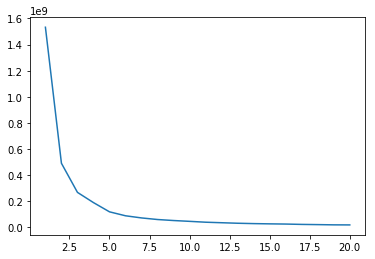

In [72]:
plt.close()
plt.plot(xAxis,yAxis)
plt.show()

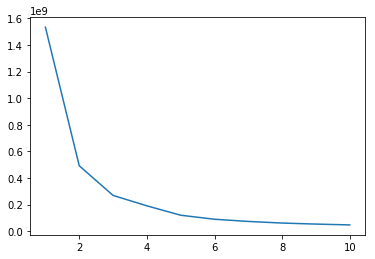

In [74]:
plt.close()
plt.plot(xAxis,yAxis)
plt.show()

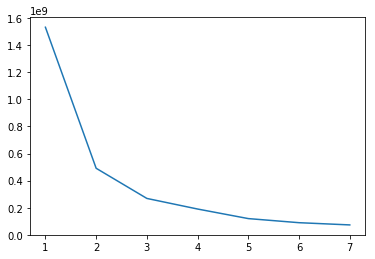

In [76]:
plt.close()
plt.plot(xAxis,yAxis)
plt.show()

In [85]:
for n in range(3):
    print label.tolist().count(n)

1780
95
363


In [87]:
from mpl_toolkits import mplot3d

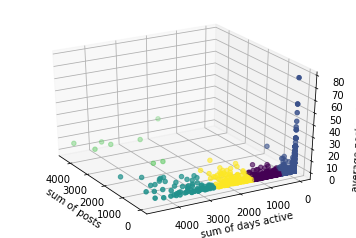

In [144]:
#[nrOfPosts,activeDays,activityPerWeek]
# voegt 3d wel iets toe, oftewel; voegt dat gemiddelde wel iets toe??
plt.close()
ax = plt.axes(projection='3d')
posts = [z[0] for z in data] #x
active = [y[1] for y in data] #y
weekactivity = [z[2] for z in data] #z
ax.scatter3D(posts, active, weekactivity, c=label);
ax.set_xlabel('sum of posts')
ax.set_ylabel('sum of days active')
ax.set_zlabel('average posts per week');
ax.view_init(30, 150)
plt.show()

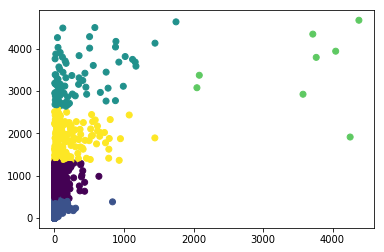

In [143]:
plt.close()
plt.scatter(posts,active, c = label)
plt.show()